In [22]:
# Path to the combined CSV file
CSV_PATH = "/home/renga/Desktop/neoen_data/renga_work/data/grid_penalty/combined_with_imbalance.csv" 

# Optional date window for plots (set to None to show everything)
START_DATE = None     # e.g., "2025-09-01"
END_DATE   = None     # e.g., "2025-09-30"

# How to treat equality (long == DA or short == DA)
# 'strict'       -> equals => indeterminate (0)
# 'equals_as_gt' -> treat equals as greater-or-equal
# 'equals_as_lt' -> treat equals as less-or-equal
EQUALITY_MODE = "strict"

# Limit points for plotting to keep charts responsive
MAX_PLOT_POINTS = 2000

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12, 6)


In [23]:
df = pd.read_csv(CSV_PATH)
print("Loaded:", CSV_PATH, "shape:", df.shape)
df.head()


Loaded: /home/renga/Desktop/neoen_data/renga_work/data/grid_penalty/combined_with_imbalance.csv shape: (8545, 6)


,measure_date,measure_date_UTC,imbalance,positive_imbalance_settlement_price,negative_imbalance_settlement_price,da_price_15min
0,2025-07-06 22:00:00.0000000 +00:00,2025-07-06 22:00:00+00:00,-128.0,42.61,46.15,46.35
1,2025-07-06 22:15:00.0000000 +00:00,2025-07-06 22:15:00+00:00,-104.0,39.36,42.62,46.35
2,2025-07-06 22:30:00.0000000 +00:00,2025-07-06 22:30:00+00:00,27.0,-30.10,-27.80,46.35
3,2025-07-06 22:45:00.0000000 +00:00,2025-07-06 22:45:00+00:00,198.0,-35.73,-32.99,46.35
4,2025-07-06 23:00:00.0000000 +00:00,2025-07-06 23:00:00+00:00,21.0,19.09,20.67,35.82


In [25]:
def find_first_matching(cols, candidates):
    lower_map = {c.lower(): c for c in cols}
    for cand in candidates:
        for col_lower, original in lower_map.items():
            if cand in col_lower:
                return original
    return None

cols = list(df.columns)

measure_candidates  = ["measure_date"]
da_candidates       = ["da_price", "da_price_15min"]
long_candidates     = ["long", "positive_imbalance_settlement_price"]
short_candidates    = ["short", "negative_imbalance_settlement_price"]
imbalance_candidates= ["imbalance"]

measure_col  = find_first_matching(cols, measure_candidates)
da_col       = find_first_matching(cols, da_candidates)
long_col     = find_first_matching(cols, long_candidates)
short_col    = find_first_matching(cols, short_candidates)
imbalance_col= find_first_matching(cols, imbalance_candidates)

detected = {
    "measure": measure_col,
    "day_ahead_price": da_col,
    "long_price": long_col,
    "short_price": short_col,
    "imbalance": imbalance_col,
}
print("Detected columns:", detected)

required = [da_col, long_col, short_col, imbalance_col]
if any(v is None for v in required):
    raise ValueError("Missing one or more required columns. Adjust candidates or rename your columns.")


Detected columns: {'measure': 'measure_date', 'day_ahead_price': 'da_price_15min', 'long_price': 'positive_imbalance_settlement_price', 'short_price': 'negative_imbalance_settlement_price', 'imbalance': 'imbalance'}


In [26]:
if measure_col is not None:
    df[measure_col] = pd.to_datetime(df[measure_col], errors="coerce")
    print("NaT in time column:", df[measure_col].isna().sum())

for c in [da_col, long_col, short_col, imbalance_col]:
    df[c] = pd.to_numeric(df[c], errors="coerce")
    print(f"NaN in {c}:", df[c].isna().sum())

NaT in time column: 0
NaN in da_price_15min: 0
NaN in positive_imbalance_settlement_price: 0
NaN in negative_imbalance_settlement_price: 0
NaN in imbalance: 0


In [27]:
def predicted_sign_row(da, lo, sh, equality_mode="strict"):
    if any(pd.isna(v) for v in [da, lo, sh]):
        return np.nan

    if equality_mode == "equals_as_gt":
        if (lo >= da) and (sh >= da) and ((lo > da) or (sh > da)):
            return 1
        if (lo <= da) and (sh <= da) and ((lo < da) or (sh < da)):
            return -1
        return 0

    if equality_mode == "equals_as_lt":
        if (lo <= da) and (sh <= da) and ((lo < da) or (sh < da)):
            return -1
        if (lo >= da) and (sh >= da) and ((lo > da) or (sh > da)):
            return 1
        return 0

    # strict: equals => indeterminate
    if (lo > da) and (sh > da):
        return 1
    if (lo < da) and (sh < da):
        return -1
    return 0  # mixed or any equality => indeterminate

df["predicted_sign"] = df.apply(
    lambda r: predicted_sign_row(r[da_col], r[long_col], r[short_col], EQUALITY_MODE),
    axis=1
)

# Actual sign from imbalance column (positive/negative/zero)
df["actual_sign"] = np.sign(df[imbalance_col])

# Match / status
df["match"] = df["predicted_sign"] == df["actual_sign"]
df["status"] = np.select(
    [
        df["predicted_sign"].isna() | df["actual_sign"].isna(),
        df["predicted_sign"] == 0,
        df["match"]
    ],
    [
        "Missing/NaN",
        "Indeterminate (mixed/equal)",
        "Match"
    ],
    default="Mismatch"
)

df[[measure_col, da_col, long_col, short_col, imbalance_col, "predicted_sign", "actual_sign", "status"]].head(3)


,measure_date,da_price_15min,positive_imbalance_settlement_price,negative_imbalance_settlement_price,imbalance,predicted_sign,actual_sign,status
0,2025-07-06 22:00:00+00:00,46.35,42.61,46.15,-128.0,-1,-1.0,Match
1,2025-07-06 22:15:00+00:00,46.35,39.36,42.62,-104.0,-1,-1.0,Match
2,2025-07-06 22:30:00+00:00,46.35,-30.10,-27.80,27.0,-1,1.0,Mismatch


In [28]:
total = len(df)
cnt = df["status"].value_counts(dropna=False)
print("--------Summary--------")
print(cnt.to_string())

indet = (df["status"] == "Indeterminate (mixed/equal)").sum()
missing = (df["status"] == "Missing/NaN").sum()
valid = total - indet - missing
if valid > 0:
    acc = (df["status"] == "Match").sum() / valid
    print(f"\nMatch rate (excluding Indeterminate & Missing): {acc:.2%}")
else:
    print("\nNo valid rows to score.")

print("\nCrosstab (Predicted vs Actual)")
print(pd.crosstab(df["predicted_sign"], df["actual_sign"]).rename_axis(index="Predicted", columns="Actual"))


--------Summary--------
status
Mismatch                       6607
Match                          1644
Indeterminate (mixed/equal)     294

Match rate (excluding Indeterminate & Missing): 19.92%

Crosstab (Predicted vs Actual)
Actual     -1.0   0.0   1.0
Predicted                  
-1          964    23  3550
 0          164     1   129
 1         3013    21   680


In [29]:
df_plot = df.copy()
if measure_col is not None and (START_DATE or END_DATE):
    mask = pd.Series(True, index=df_plot.index)
    if START_DATE:
        mask &= df_plot[measure_col] >= pd.to_datetime(START_DATE)
    if END_DATE:
        mask &= df_plot[measure_col] <= pd.to_datetime(END_DATE)
    df_plot = df_plot[mask]

if len(df_plot) > MAX_PLOT_POINTS:
    df_plot = df_plot.iloc[:MAX_PLOT_POINTS].copy()

print("Plotting rows:", len(df_plot))


Plotting rows: 2000


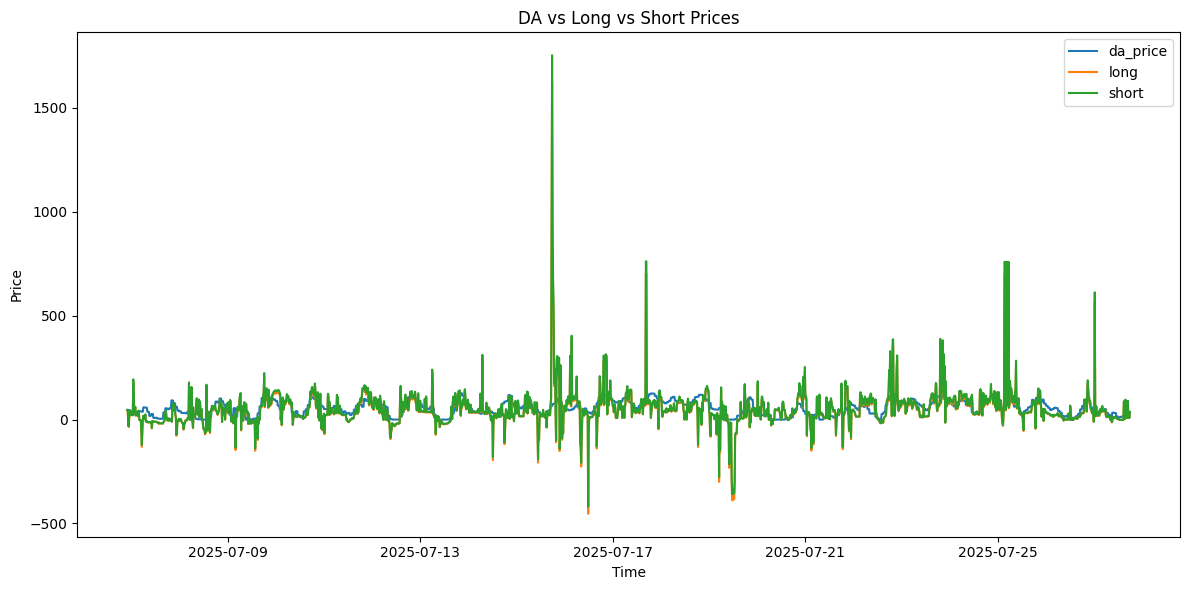

In [ ]:
if measure_col is None:
    print("No time column detected; skipping time series plot.")
else:
    temp = df_plot[[measure_col, da_col, long_col, short_col]].dropna().sort_values(measure_col)
    if temp.empty:
        print("Nothing to plot in selected window.")
    else:
        plt.figure()
        plt.plot(temp[measure_col], temp[da_col],  label=da_col)
        plt.plot(temp[measure_col], temp[long_col], label=long_col)
        plt.plot(temp[measure_col], temp[short_col],label=short_col)
        plt.legend()
        plt.title("DA vs Long vs Short Prices")
        plt.xlabel("Time")
        plt.ylabel("Price")
        plt.tight_layout()
        plt.show()
